## Overview

This tutorial describes the blind source separation problem, and a class of techniques used to solve it called Independent Component Analysis (ICA). A classic example used to illustrate the problem is that of N people in a room  talking to each other. Suppose there are an equal number (N) of microphones placed at different points in the room, the signal recorded by each being a mixture of the individual voices. The goal of the blind source separation is to separate the voice signal of each source (i.e. each person) from these N mixtures.

Lets now state the problem formally. Let s be the N-dimensional vector of source signal values. We assume the sources are independent random variables. Let x be the corresponding N-dimensional vector of observations (one for each microphone in the example above). Each observation is a linear combination of the sources, so:

$$x = As,$$

where A is a N x N matrix called the mixing matrix. Given a set of M samples of observation vectors, $\{x^{(i)}\}$, we want to compute $A^{-1}$, so that we can extract $s^{(i)} = A^{-1} x^{(i)}$ for each i. The plot below illustrates the setup. Note that while the source samples (in blue) are uniformly scattered, the observations (in yellow) are concentrated around a line---this fact is going to be the basis of algorithms below.

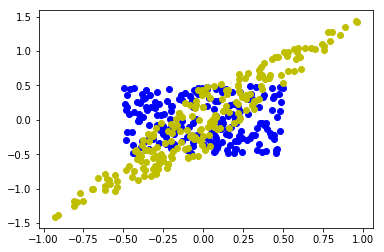

In [325]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

rnd.seed(0)

# N x M matrix, each column of length N is a sample of the sources.
M = 200
N = 2
S = rnd.rand(N, M) - 0.5  # centre the sources to have 0 mean
A = np.array([[1, 1], [1, 2]])
X = np.matmul(A, S)

plt.scatter(S[0, :], S[1, :], c='b')
plt.scatter(X[0, :], X[1, :], c='y')
plt.show()


## Separability

There is a limit on the degree to which one can unambiguously separate the sources.

First, consider scaling any of the sources, say $s_j$, by any $c$ and the corresponding $j^{th}$ column of matrix A by $1/c$. This produces the same observation $x = As$ as before, so we can only separate each source modulo an unknown scalar multiple.

Second, consider swapping the order of any 2 sources $i$ and $j$---if $s = [s_0, s_1, \dots s_i, \dots s_j, \dots s_{N-1}]^{t}$, let $s' = [s_0, s_1, \dots s_j, \dots s_i, \dots s_{N-1}]^{t}$, and let $A'$ be the matrix obtained by swapping the $i^{th}$ and $j^{th}$ columns of $A$. Then $As = A's'$, which means we cannot uniquely identify the relative order of the sources either.

The above points illustrate the extent to which we can separate the sources when they are separable. But are sources always separable? Turns out there is one case where they are not: when they are gaussian distributed.  Consider  gaussian sources $s_0, s_1, \dots, s_{N-1}$, each with $0$ mean and variance $1$. Recall that the sources are assumed to be independent, so this means the covariance matrix of $s$ is the $N \times N$ identity matrix $I_N$. 

Let $R$ be a orthogonal matrix $R$, i.e. $R^t = R^{-1}$. An example of a $2 \times 2$ orthogonal matrix is one which rotates the coordinates of a vector by an angle $\theta$:

$$
R = 
\begin{bmatrix}
\cos \theta & \sin \theta \\
\sin \theta  & -\cos \theta
\end{bmatrix}.
$$

Consider another source $s'$, defined as $s' = Rs$, which has covariance matrix

$$E[s's'^t]~=~E[(Rs)(Rs)^t]~=~E[Rss^tR^t]~=~RE[ss^t]R^t~=~RI_NR^t=RR^{-1}~=~I_N, $$

the same as $s$. So $s, s'$ have identical distributions, and therefore the observations generated by $s'$ and $A$, i.e, $x' = As'$ will also have the same distribution as $x = As$ above. However $x', x$ are generated from distinct sources $s', s$, and hence we cannot tell the 2 sources apart from the observations. Here we used the property of zero-centred multi-dimensional gaussians that their distribution is uniquely determined by their covariance matrix. The scatter plot of distributions of $x$ (blue) and $x'$ (yellow) below illustrates this.



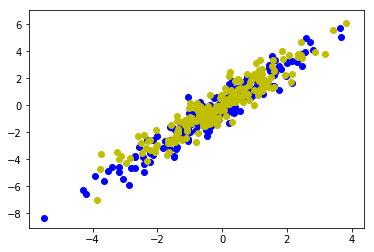

In [326]:
# Illustration for N = 2 gaussian sources
S = rnd.randn(N, M)
# Orthogoinal matrix
R = np.array([[np.cos(np.pi/4),  np.sin(np.pi/4)],
              [np.sin(np.pi/4), -np.cos(np.pi/4)]])
# Another source obtained by rotating S by 45 degrees.
Sp = np.matmul(R, S)

X = np.matmul(A, S)   # observations generated by source S
Xp = np.matmul(A, Sp) # generated by Sp

# Both X, Xp look identically distributed.
plt.scatter(X[0, :], X[1, :], c='b')
plt.scatter(Xp[0, :], Xp[1, :], c='y')
plt.show()

## ICA Algorithms

Recall that the sources $s$ are assumed to be independent. However, the elements of $s$ do not remain independent after the linear transformation $x = As$, as illustrated by the topmost plot. So one way to separate the sources is to find a matrix $W$ such that the elements of $y = Wx$ are independent. The value of $A$ is then obtained by $A = W^{-1}$. In practice, it may not be possible to get completely independent sources, so we want to find a $W$ that minimizes some measure of dependence. In this context, note that the difficulty of separating gaussians arises from the fact that applying a linear transformation to a vector of independent gaussian sources (such using the rotation $R$ above) can preserve the independence. How can we measure (in)dependence? Correlation is one possibilty, but as we know, zero correlation does not always imply independence. A better measure of dependence is mutual information, defined for a vector of random variables $y$ as:
$$I(y) = \sum_{i} H(y_i)~-~H(y),$$
where $H$ denotes the entropy  of a random variable, $H(z) = E[-\ln(p(z))]$, $p(z)$ being the density of $z$. Intuitively, entropy measures the "degree of randomness" of a set of random variables, and hence the more independent the elements in $y$, namely $y_0, y_1, \dots$, the larger the value of $H(y)$, and smaller the value of $I(y)$. So we can try to find a $W$ that minimizes $I(y),~y = Wx$.

It turns out that mutual information is also closely related to another quantity called  negentropy, defined as:
$$J(y) = H(g)~−~H(y), $$
where $g$ denotes a $N$-dimensional gaussian (same dimension as $y$) having the same covariance matrix as $y$. One can prove that $J(y)$ is smallest when, and only when, $y$ is gaussian too. So $J(y)$ measures the extent to which $y$ is non-gaussian, and we want to find a $W$ that maximizes it. The intutiton behind this is that when the sources $s_0, s_1, \dots$ are non-gaussians, their weighted sums, i.e, the observations $x = As$ are more gaussian---indeed, this is what the central limit theorem states as the number of sources tends to infinity. Below we show the usage of one algorithm called Fast ICA, included in the sklearn package, that minimizes an approximation of negentropy.

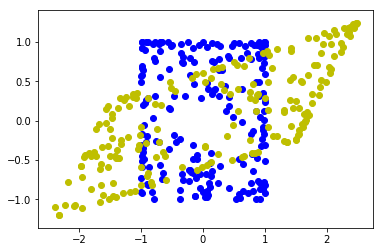

In [327]:
from sklearn.decomposition import FastICA

S = rnd.rand(N, M)
S[0,:] = np.sin(2 * S[0,:] * np.pi)
S[1, :] = np.cos(2 * S[1,:] * np.pi)

plt.scatter(S[0,:], S[1,:], c='b')

# The mixing matrix.
A = np.array([[0.5, 2], [.75, 0.5]])
X = np.matmul(A, S)  # generate observations.

plt.scatter(X[0,:], X[1,:], c='y')
plt.show()


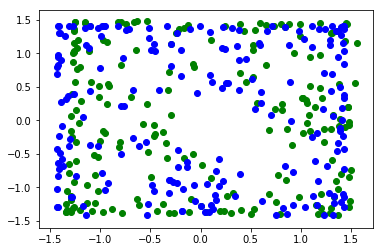

Estimate of A = 
 [[-20.06377375  -4.27450042]
 [ -5.10561396  -7.23736399]]


In [328]:
fast_ica = FastICA(n_components=2)
Y = fast_ica.fit_transform(X.T)  # estimate of the sources
Winv = fast_ica.mixing_  # estimate of A

# Note that we can only recover A and the sources modulo a permutation of 
# sources, i.e., source 0 and 1 may be swapped in the output. Also the sources 
# and the columns of A can be scaled arbitrarily.
# So normalize the variance to 1 for each source so as to get comparable scales
# in the plot below.
S = (S.T / S.std(axis=1)).T
Y = (Y / Y.std(axis=0))
plt.scatter(Y[:, 0], Y[:, 1], c='g')
plt.scatter(S[0,:], S[1,:], c='b')

plt.show()

print("Estimate of A = \n", Winv)

### Maximum Likelihood Based Algorithm

Lets describe another widely-used alternative approach based on maximum likelihood, known in the context of ICA as the Bell-Sejnowski algorithm, which we are going to implement here. We have a generative model for the observations, $x = As$. If we knew the family of density functions that sources in $s$ belonged to, we could compute the log-likelihood of the observations $\{x^{(i)}\}$ in terms of $A$ and then maximize it. If we do not know what the densities look like, we can make assumptions. Keep in mind that we cannot assume them to be gaussian, as we saw above---the maxima of likelihood function in this case gives us no information. In the Bell-Sejnowski algorithm we would assume a non-gaussian function like the following for each source s_i:
$$ p_i(t)~=~\frac{e^{-t}}{(1 + e^{-t})^2}, $$
the cdf of which is the sigmoid $\frac{1}{(1 + e^{-t})}$. For this particular density, one can show that the loglikehood function is given by

$$\prod_{j=0}^{M-1}\prod_{i=0}^{N-1}~p_i(W_ix^{(j)}) \det(W),$$
where $W_i$ is the $i^{th}$ row of $W$.

The derivative of the loglikelihood can now be maximixed in a gradient ascent algorithm. The gradient of loglikelihood  turns out to be:

$$ (W^t)^{-1} + \frac{1}{M}\sum_{j}
\begin{bmatrix}
g_0(W_0x^{(j)}) \\
g_1(W_1x^{(j)})\\
\dots \\
g_i(W_ix^{(j)})\\
\dots \\
\end{bmatrix}  (x^{(j)})^t,
$$
where function $g_i(t) =  \frac{d}{dt}(\ln p_i(t))$.

Before applying this algorithm, it is a good idea to preprocess the data as follows.


In [329]:
import numpy.linalg

def centre(X):
    # Shift mean to 0
    mu = np.reshape(X.mean(axis=1), newshape=(X.shape[0], 1))
    return X - np.matmul(mu, np.ones([1, X.shape[1]]))

def whiten(X):
    # Transorms X (with 0 mean) to have identity covariance matrix.
    cov = np.matmul(X, X.T) / X.shape[1]
    # eignevalue decomposition, cov = V * diag(L) * V^t
    L, V = np.linalg.eigh(cov)
    D = np.diag(L ** -0.5)
    T = np.matmul(V, np.matmul(D, V.T))
    return (T, np.matmul(T, X))

# Preprocess signals in X to be 0-centred, and all pairs of signals to be uncorrelated.
(T, Xp) = whiten(centre(X))


Next, we implement the algorithm.

In [330]:
class MLSeparator:
    def __init__(self, alpha=0.1, eps=0.01, batch=-1, step=''):
        self.alpha = alpha # optimizer step size
        self.eps = eps # early stopping criterion for optimizer
        # step can be set to 'natural', in which case we use
        # natural_gradient_step below for gradient ascent.
        self.step = step
        # Batch size to use for gradient ascent. -1 means use all points.
        self.batch = batch
    
    def log_density_derivative(t):
        # Returns derivative of log of density for a sigmoid CDF.
        return 1 - 2 / (1 + np.exp(-t))
    
    def loglikelihood(W, Y):
        pdf = lambda t : np.exp(-t) / (1 + np.exp(-t))**2  # density for sigmoid CDF.
        return np.log(pdf(Y)).sum() / Y.shape[1] + np.log(abs(np.linalg.det(W)))
    
    def natural_gradient_step(X, Y, W):
        G = MLSeparator.log_density_derivative(Y)
        M = np.matmul(G, Y.T) / Y.shape[1] + np.identity(W.shape[0])
        return np.matmul(M, W)
    
    def default_gradient_step(X, Y, W):
        M = X.shape[1] # batch size
        G = MLSeparator.log_density_derivative(Y)
        return np.matmul(G, X.T) / M + np.linalg.inv(W.T)
    
    def separate(self, X):
        # X: N x M matrix of M samples, centred and whitened.
        # Outputs tuple (Y, W) where Y is N x M matrix of sources, and
        # W is a N x N matrix such that Y = WX
        W = rnd.rand(X.shape[0], X.shape[0])  # random initialization
        gradient_step = MLSeparator.natural_gradient_step if self.step == 'natural' else MLSeparator.default_gradient_step
        batch = self.batch if self.batch > 0 else X.shape[1]
        maxsteps = 1000 * X.shape[1] / batch # update a maximum of 1000 times for each column in X. 
        start = 0
        loglike_prev = -np.inf  # initialize the loglikelihood to be a -infinity
        while True:
            Y = np.matmul(W, X)
            loglike = MLSeparator.loglikelihood(W, Y)
            # We process the batch consisting of columns from index = start to index = fin - 1.
            fin = min(start + batch, X.shape[1])
            Wnew = W + self.alpha * gradient_step(X[:, start:fin], Y[:, start:fin], W)
            if abs(loglike_prev - loglike) < self.eps or maxsteps == 0:
                break
            W = Wnew
            loglike_prev = loglike
            maxsteps -= 1
            start = (start + batch) % X.shape[1]
        return (Y, W)


Finally, we iterate over a few possible batch and step sizes to find the one that gives us the best log likelihood.
Some observations:
-  We implemented two types of gradient step update, the default (described above) and an alternative called 'natural' that does not need matrix inversion but for us did not perform so well.
- Our algorithm does worse than FastICA. It is possible to try more complex optimizers to improve it, but our point here is to give a basic understanding of the Bell-Sejnowski algorithm.

Estimated mixing matrix = 
 [[ 0.99247363 -0.06128795]
 [ 0.31411923  0.2783172 ]]


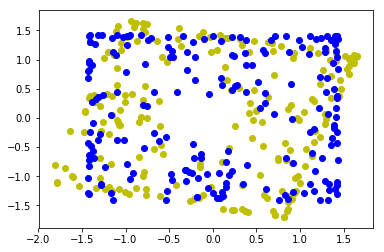

In [347]:
# Find the best step size and batch size.
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]
batches = [1, 10, 50, 100, -1]
best_loglike = -np.inf
for a in alpha_values:
    for b in batches:
        mlsep = MLSeparator(alpha=a, eps=0.005, batch=b)
        (Ycurr, Wcurr) = mlsep.separate(Xp)
        loglike = MLSeparator.loglikelihood(Wcurr, Ycurr)
        if loglike > best_loglike:
            # print("alpha_value = ", a , " batch size = ", b, " loglikehood = ", loglike)
            best_loglike = loglike
            W = Wcurr
            Y = Ycurr

# Undo the whitening and centering applied earlier.
# S was chosen to be approximately centred anyway, so we omit the latter.
W = np.matmul(W, T)
print("Estimated mixing matrix = \n", np.linalg.inv(W))
# Match the scale Y to be approx that of S for the purposes of visualization.
Y = (Y.T / Y.std(axis=1)).T
plt.scatter(Y[0, :], Y[1, :], c='y')
plt.scatter(S[0, :], S[1, :], c='b')
plt.show()

## References
(1) Independent Component Analysis: Algorithms and Applications, Aapo Hyvärinen and Erkki Oja, Neural Networks, 13(4-5):411-430, 2000

(2) https://www.mv.helsinki.fi/amoaning/movies/uml/ica_handout3.pdf

(3) Fast ICA reference: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA